In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn
import sys

Train set dimension: 125973 rows, 42 columns
Test set dimension: 22544 rows, 42 columns
Original dataset shape Counter({1: 67343, 0: 45927, 2: 11656, 3: 995, 4: 52})
Resampled dataset shape Counter({1: 67343, 0: 67343, 3: 67343, 2: 67343, 4: 67343})
['src_bytes', 'dst_bytes', 'logged_in', 'count', 'srv_count', 'dst_host_srv_count', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_serror_rate', 'service']
Normal_DoS
Normal_Probe
Normal_R2L
Normal_U2R


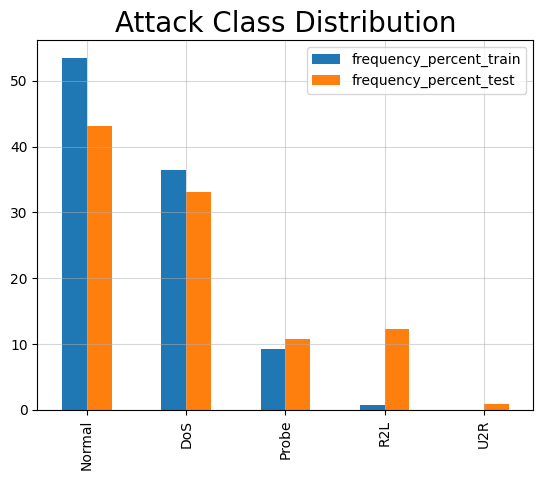

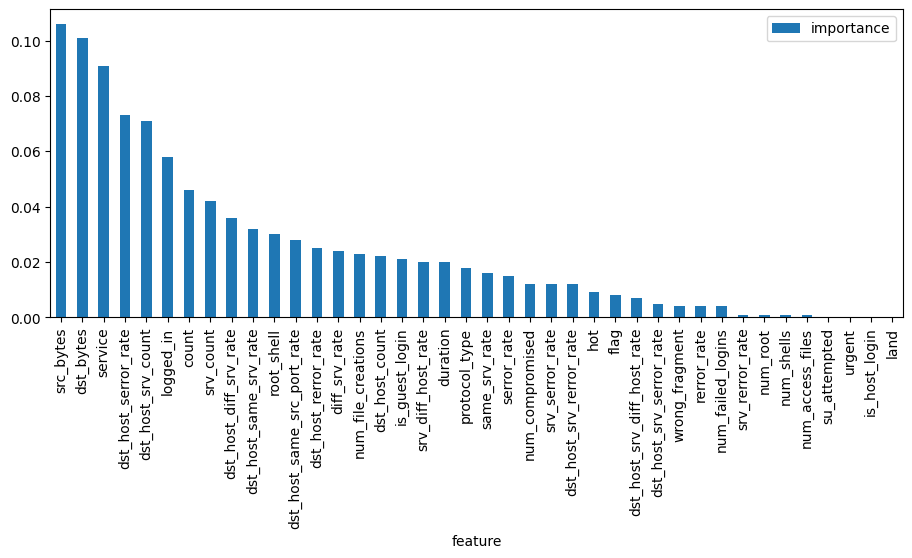

In [ ]:

datacols = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",



    "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

dfkdd_train = pd.read_table("/content/drive/MyDrive/minor/KDDTrain.txt", sep=",", names=datacols)
dfkdd_train = dfkdd_train.iloc[:,:-1]


dfkdd_test = pd.read_table("/content/drive/MyDrive/minor/KDDTest.txt", sep=",", names=datacols)
dfkdd_test = dfkdd_test.iloc[:,:-1]
dfkdd_train.head(10)
print('Train set dimension: {} rows, {} columns'.format(dfkdd_train.shape[0], dfkdd_train.shape[1]))

dfkdd_test.head(10)
print('Test set dimension: {} rows, {} columns'.format(dfkdd_test.shape[0], dfkdd_test.shape[1]))

mapping = {'ipsweep': 'Probe','satan': 'Probe','nmap': 'Probe','portsweep': 'Probe','saint': 'Probe','mscan': 'Probe',
        'teardrop': 'DoS','pod': 'DoS','land': 'DoS','back': 'DoS','neptune': 'DoS','smurf': 'DoS','mailbomb': 'DoS',
        'udpstorm': 'DoS','apache2': 'DoS','processtable': 'DoS',
        'perl': 'U2R','loadmodule': 'U2R','rootkit': 'U2R','buffer_overflow': 'U2R','xterm': 'U2R','ps': 'U2R',
        'sqlattack': 'U2R','httptunnel': 'U2R',
        'ftp_write': 'R2L','phf': 'R2L','guess_passwd': 'R2L','warezmaster': 'R2L','warezclient': 'R2L','imap': 'R2L',
        'spy': 'R2L','multihop': 'R2L','named': 'R2L','snmpguess': 'R2L','worm': 'R2L','snmpgetattack': 'R2L',
        'xsnoop': 'R2L','xlock': 'R2L','sendmail': 'R2L',
        'normal': 'Normal'}
dfkdd_train['attack_class'] = dfkdd_train['attack'].apply(lambda v: mapping[v])
dfkdd_test['attack_class'] = dfkdd_test['attack'].apply(lambda v: mapping[v])
dfkdd_train.drop(['attack'], axis=1, inplace=True)
dfkdd_test.drop(['attack'], axis=1, inplace=True)
dfkdd_train.head(10)

dfkdd_train.describe()

dfkdd_train['num_outbound_cmds'].value_counts()

dfkdd_test['num_outbound_cmds'].value_counts()

dfkdd_train.drop(['num_outbound_cmds'], axis=1, inplace=True)
dfkdd_test.drop(['num_outbound_cmds'], axis=1, inplace=True)
attack_class_freq_train = dfkdd_train[['attack_class']].apply(lambda x: x.value_counts())
attack_class_freq_test = dfkdd_test[['attack_class']].apply(lambda x: x.value_counts())
attack_class_freq_train['frequency_percent_train'] = round((100 * attack_class_freq_train / attack_class_freq_train.sum()),2)
attack_class_freq_test['frequency_percent_test'] = round((100 * attack_class_freq_test / attack_class_freq_test.sum()),2)
attack_class_dist = pd.concat([attack_class_freq_train,attack_class_freq_test], axis=1,sort = False)
attack_class_dist

plot = attack_class_dist[['frequency_percent_train', 'frequency_percent_test']].plot(kind="bar");
plot.set_title("Attack Class Distribution", fontsize=20);
plot.grid( alpha=0.5);

dfkdd_train.head()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cols = dfkdd_train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(dfkdd_train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(dfkdd_test.select_dtypes(include=['float64','int64']))
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
cattrain = dfkdd_train.select_dtypes(include=['object']).copy()
cattest = dfkdd_test.select_dtypes(include=['object']).copy()
traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)
enctrain = traincat.drop(['attack_class'], axis=1)
enctest = testcat.drop(['attack_class'], axis=1)
cat_Ytrain = traincat[['attack_class']].copy()
cat_Ytest = testcat[['attack_class']].copy()

from imblearn.over_sampling import RandomOverSampler
from collections import Counter
sc_traindf = dfkdd_train.select_dtypes(include=['float64','int64'])
refclasscol = pd.concat([sc_traindf, enctrain], axis=1).columns
refclass = np.concatenate((sc_train, enctrain.values), axis=1)
X = refclass
c, r = cat_Ytest.values.shape
y_test = cat_Ytest.values.reshape(c,)

c, r = cat_Ytrain.values.shape
y = cat_Ytrain.values.reshape(c,)
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)

print('Original dataset shape {}'.format(Counter(y)))

print('Resampled dataset shape {}'.format(Counter(y_res)))

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10);
rfc.fit(X_res, y_res);

score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':refclasscol,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

from sklearn.feature_selection import RFE
import itertools
rfc = RandomForestClassifier(n_estimators=10);
rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_res, y_res)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), refclasscol)]

selected_features = [v for i, v in feature_map if i==True]
print(selected_features)

newcol = list(refclasscol)
newcol.append('attack_class')
new_y_res = y_res[:, np.newaxis]

res_arr = np.concatenate((X_res, new_y_res), axis=1)
res_df = pd.DataFrame(res_arr, columns = newcol)

reftest = pd.concat([sc_testdf, testcat], axis=1)
reftest['attack_class'] = reftest['attack_class'].astype(np.float64)
reftest['protocol_type'] = reftest['protocol_type'].astype(np.float64)
reftest['flag'] = reftest['flag'].astype(np.float64)
reftest['service'] = reftest['service'].astype(np.float64)
res_df.shape

reftest.shape

from collections import defaultdict
classdict = defaultdict(list)

attacklist = [('DoS', 0.0), ('Probe', 2.0), ('R2L', 3.0), ('U2R', 4.0)]
normalclass = [('Normal', 1.0)]

def create_classdict():
    for j, k in normalclass:
        for i, v in attacklist:
            restrain_set = res_df.loc[(res_df['attack_class'] == k) | (res_df['attack_class'] == v)]
            classdict[j +'_' + i].append(restrain_set)
            # test labels
            reftest_set = reftest.loc[(reftest['attack_class'] == k) | (reftest['attack_class'] == v)]
            classdict[j +'_' + i].append(reftest_set)
create_classdict()

for k, v in classdict.items():
    print(k)

In [ ]:
pretrain = classdict['Normal_DoS'][0]
pretest = classdict['Normal_DoS'][1]
grpclass = 'Normal_DoS'
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

Xresdf = pretrain
newtest = pretest

Xresdfnew = Xresdf[selected_features]
Xresdfnum = Xresdfnew.drop(['service'], axis=1)
Xresdfcat = Xresdfnew[['service']].copy()

Xtest_features = newtest[selected_features]
Xtestdfnum = Xtest_features.drop(['service'], axis=1)
Xtestcat = Xtest_features[['service']].copy()


# Fit train data
enc.fit(Xresdfcat)

# Transform train data
X_train_1hotenc = enc.transform(Xresdfcat).toarray()

# Transform test data
X_test_1hotenc = enc.transform(Xtestcat).toarray()

X_train = np.concatenate((Xresdfnum.values, X_train_1hotenc), axis=1)
X_test = np.concatenate((Xtestdfnum.values, X_test_1hotenc), axis=1)

y_train = Xresdf[['attack_class']].copy()
c, r = y_train.values.shape
Y_train = y_train.values.reshape(c,)

y_test = newtest[['attack_class']].copy()
c, r = y_test.values.shape
Y_test = y_test.values.reshape(c,)
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

# Train KNeighborsClassifier Model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train, Y_train);

# Train LogisticRegression Model
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier.fit(X_train, Y_train);

# Train Gaussian Naive Baye Model
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, Y_train)

# Train Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(X_train, Y_train);

# Train RandomForestClassifier Model
#RF_Classifier = RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=0)
#RF_Classifier.fit(X_train, Y_train);

# Train SVM Model
#SVC_Classifier = SVC(random_state=0)
#SVC_Classifier.fit(X_train, Y_train)

## Train Ensemble Model (This method combines all the individual models above except RandomForest)
#combined_model = [('Naive Baye Classifier', BNB_Classifier),
#                  ('Decision Tree Classifier', DTC_Classifier),
#                  ('KNeighborsClassifier', KNN_Classifier),
#                  ('LogisticRegression', LGR_Classifier)
#                 ]
#VotingClassifier =  VotingClassifier(estimators = combined_model,voting = 'soft', n_jobs=-1)
#VotingClassifier.fit(X_train, Y_train);
from sklearn import metrics

models = []
#models.append(('SVM Classifier', SVC_Classifier))
models.append(('Naive Baye Classifier', BNB_Classifier))
models.append(('Decision Tree Classifier', DTC_Classifier))
#models.append(('RandomForest Classifier', RF_Classifier))
models.append(('K Neighbors Classifier', KNN_Classifier))
models.append(('Logistic Regression Classifier', LGR_Classifier))
#models.append(('VotingClassifier', VotingClassifier))

for i, v in models:
    scores = cross_val_score(v, X_train, Y_train, cv=10)
    accuracy = metrics.accuracy_score(Y_train, v.predict(X_train))
    confusion_matrix = metrics.confusion_matrix(Y_train, v.predict(X_train))
    classification = metrics.classification_report(Y_train, v.predict(X_train))
    print()
    print('============================== {} {} Model Evaluation =============================='.format(grpclass, i))
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification)
    print()


============================== Normal_DoS Naive Baye Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9737760413571536

Model Accuracy:
 0.9737686173767133

Confusion matrix:
 [[65346  1997]
 [ 1536 65807]]

Classification report:
               precision    recall  f1-score   support

         0.0       0.98      0.97      0.97     67343
         1.0       0.97      0.98      0.97     67343

    accuracy                           0.97    134686
   macro avg       0.97      0.97      0.97    134686
weighted avg       0.97      0.97      0.97    134686



============================== Normal_DoS Decision Tree Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9997698368976862

Model Accuracy:
 0.9999480272634127

Confusion matrix:
 [[67343     0]
 [    7 67336]]

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     67343
        